# Лабораторная работа №3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
from sympy import *
from IPython.display import display, Latex

### В данной работе будут реализованы численное решение нелинейного уравнения методом простой итерации, а также численное решение НЛАУ методом Ньютона.

# Нелинейное уравнение

### Решать будем прекрасное уравнение (12.4 (к)):
$$\ln x + (x - 1)^3 = 0$$

In [2]:
def equation (x):
    return np.log(x) + (x - 1)**3

### Построим график $f(x) = \ln{x} + (x - 1)^3$:

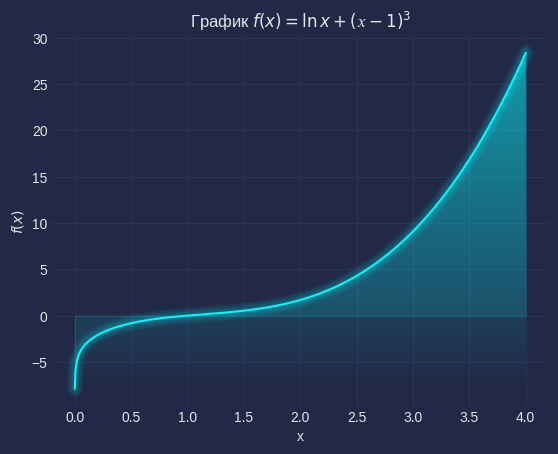

In [3]:
plt.style.use("cyberpunk")

plt.title(r'График $f(x)=\ln x+(𝑥−1)^3$')
x = np.linspace (0.001, 4, num=1000)
plt.plot(x, equation(x))
plt.xlabel('x')
plt.ylabel(r'$f(x)$')

mplcyberpunk.add_glow_effects()
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.5)
plt.show()

## Оценим области локализации корней построив два метода простой итерации и решим обоими, найдя условия $| \phi' (x) | < 1$:
 - $x_{n + 1} = e^{-(x_{n} - 1)^3} \Rightarrow \phi_1 (x) = e^{-(x - 1)^3} \Rightarrow \phi_1' (x) = - 3(x - 1)^2 e^{-(x - 1)^3}$
 - $x_{n + 1} = 1 + \sqrt[3]{- \ln{x_n}} \Rightarrow \phi_2 (x) = 1 + \sqrt[3]{-\ln{x}} \Rightarrow \phi_2' (x) = \frac{\sqrt[3]{-\ln{x}}}{3 x \ln{x}}$

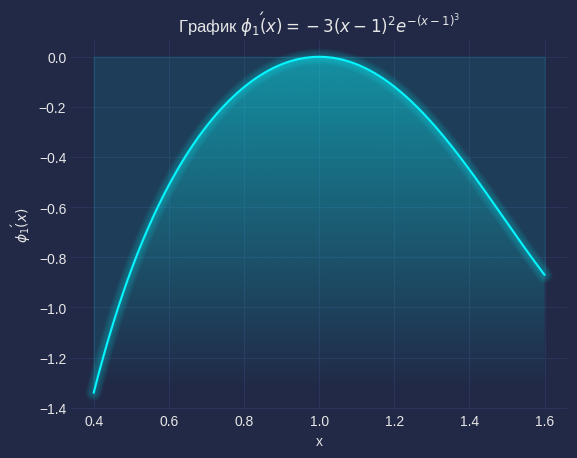

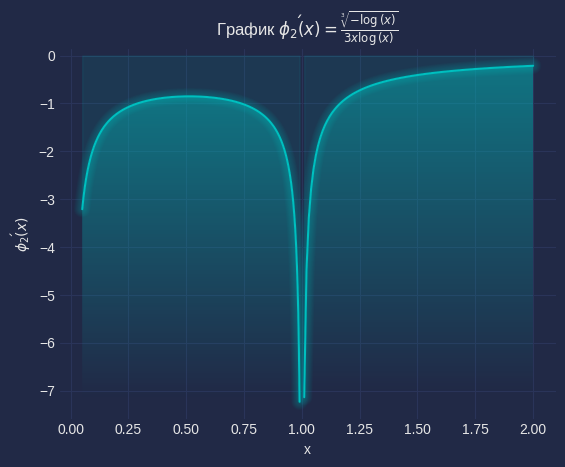

In [4]:
t = symbols('x', real=True)
init_printing(use_unicode=True)

# для phi_1
phi_1 = exp(-(t - 1)**3)
deriv_phi_1 = diff(phi_1, t)
func_deriv_phi_1 = lambdify((t), deriv_phi_1, "numpy")

# для phi_2
phi_2 = 1 + root(-log(t), 3)
deriv_phi_2 = diff(phi_2, t)

right_func_deriv_phi_2 = lambdify((t), -(log(t))**(1/3)/(3*t*log(t)), "numpy")
left_func_deriv_phi_2 = lambdify((t), deriv_phi_2, "numpy")

plt.title(r'График $\phi_1\'(x)=' + str(latex(deriv_phi_1)) + '$')
x = np.linspace (0.4, 1.6, num=1000)
plt.plot(x, func_deriv_phi_1(x))
plt.xlabel('x')
plt.ylabel(r'$\phi_1\'(x)$')

mplcyberpunk.add_glow_effects()
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.5)
plt.show()

plt.title(r'График $\phi_2\'(x)=' + str(latex(diff(phi_2, t))) + '$')
x = np.linspace (0.05, 0.99, num=1000)
plt.plot(x, left_func_deriv_phi_2(x), c='c')
x = np.linspace (1.01, 2, num=100)
plt.plot(x, right_func_deriv_phi_2(x), c='c')
plt.xlabel('x')
plt.ylabel(r'$\phi_2\'(x)$')

mplcyberpunk.add_glow_effects()
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.5)
plt.show()

## В целом, даже графически видно, что второй метод поставленному условию не удовлетворяет, а первый удовлетворяет на отрезке [0.5, 1.5], чтобы убедиться в справедливости для первого метода выведем максимума производной на указнном отрезк

In [5]:
x = np.linspace (0.5, 1.5, num=1000)
max(abs(func_deriv_phi_1(x)))

### Возьмем начальное значение 0.5:

In [6]:
func_phi_1 = lambdify((t), phi_1, "numpy")

# fix number of iterations

numIt = 4
cur = 0.5

for i in range(numIt):
    cur = func_phi_1(cur)

print('x = ' + str(cur))
print('Невязка = ' + str(abs(equation(cur))))

x = 1.0
Невязка = 0.0


### Точное значение "угадывается" и оно равно 1. Мы получаем это значение уже через 4 итерации точнее машинного нуля и невязка ($|f(x_n)|$) обнулилась.

# СНАУ:

## Напишем общие функции для метода Ньютона, а также функции для удобной печати результатов:

In [7]:
# norms of vectors

def vectorNorm1(vec):
    return np.abs(vec).max()

def vectorNorm2(vec):
    return np.abs(vec).sum()

def vectorNorm3(vec):
    return np.sqrt(np.dot(vec.T, vec)).item()

def getInvJacobian (Func, sym):
    tmp = [lambdify((sym), el, "numpy")  for el in 
            Matrix(len(sym), len(Func), [diff(Func[i], sym[j]) for j in range(len(sym)) for i in range (len(Func))]).inv()]
    return [[ tmp[i*len(sym) + j] for j in range(len(sym))] for i in range (len(Func))]

def getNumericalInvJac (invJac, point):
    tmp = [[j(*list(map(float, point))) for j in i] for i in invJac]
    return Matrix(len(invJac), len(point), [ tmp[i][j] for j in range(len(point)) for i in range(len(invJac))])

def NewtonMethod (sym, Func, current, accuracy, norm = vectorNorm3):
    Funcs = [lambdify ((sym), func, "numpy") for func in Func]
    numIt = 0
    
    while norm(np.array([func(*list(map(float, current))) for func in Funcs])) > accuracy:
        current = current - getNumericalInvJac(getInvJacobian(Func, sym), current) * Matrix(len(Func), 1, 
                                                                                    [i.evalf(subs={u: current[0, 0], v: current[1, 0]}) for i in Func])
        numIt += 1
    
    return current, numIt
# print functions

def printJacobian (Func, sym):
    display(Latex(
       rf"""
    $$J = {latex(Matrix(len(sym), len(Func), [diff(Func[i], sym[j]) for j in range(len(sym)) for i in range (len(Func))]))}$$
    """))

def printInvJacobian (Func, sym):
    display(Latex(
       rf"""
    $$J^{{-1}} = {latex(Matrix(len(sym), len(Func), [diff(Func[i], sym[j]) for j in range(len(sym)) for i in range (len(Func))]).inv())}$$
    """))

def printSolution (sym, solution):
    display(Latex(
       rf"""
    $${latex(Matrix(len(sym), 1, sym))} = {latex(solution)}$$
    """))

def printSystem (sym, system):
    full_data = ' \\\\ '.join([str(latex(eq)) for eq in system])
    display(Latex(
        rf"""
        $$F\left(\overline{{x}}\right) = \cases {{ {full_data} }}$$
        """))

def printAreaOfLocalization (sym, localizations):
    full_data = '(' + ','.join([str(s) for s in sym]) + ') \in' + '[' + \
                '] \\times ['.join([','.join([str(coord) for coord in loc]) for loc in localizations]) + ']'
    display(Latex(
        rf"""
        $${full_data}$$
        """))

def printBegin(sym, begin):
    full_data = '(' + ','.join([str(s) for s in sym]) + ') =' + '[' + \
                ','.join([str(coord) for coord in begin]) + ']'
    display(Latex(
        rf"""
        $${full_data}$$
        """))

def printAllResults(sym, Func, solution, numIt):
    Funcs = [lambdify ((sym), func, "numpy") for func in Func]
    printSolution (sym, solution)
    print(f'Достигнута искомая точность за {numIt} итераций')
    print ("Невязка по первой норме = " + str(vectorNorm1(np.array([func(*list(map(float, solution))) for func in Funcs]))))
    print ("Невязка по второй норме = " + str(vectorNorm2(np.array([func(*list(map(float, solution))) for func in Funcs]))))
    print ("Невязка по третьей норме = " + str(vectorNorm3(np.array([func(*list(map(float, solution))) for func in Funcs]))))
    print()

## Определим символы:

In [8]:
u, v = symbols("x,y")
syms = list([u, v])

## Возьмем в качестве первой системы 12.5 (г):

In [9]:
F = list([sin(u + 2) - v - 1.5, u + cos(v - 2) - 0.5])

printSystem (syms, list(Eq(func, 0) for func in F))

<IPython.core.display.Latex object>

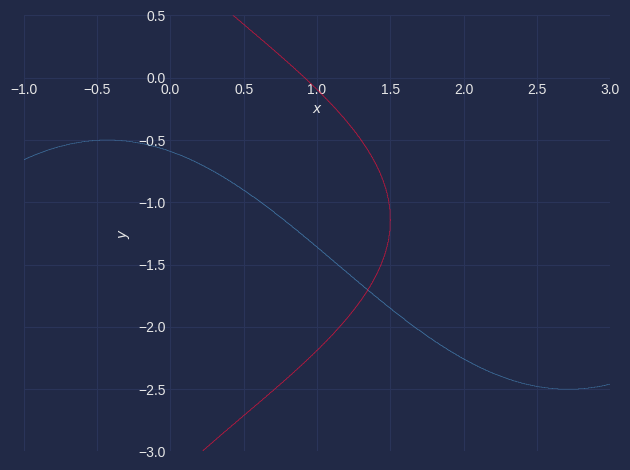

In [10]:
plot1 = plot_implicit(Eq(F[0], 0), (u, -1, 3), (v, -3, 0.5), line_color='steelblue', show=False)
plot2 = plot_implicit(Eq(F[1], 0), (u, -1, 3), (v, -3, 0.5), line_color='crimson', show=False)
plot1.append(plot2[0])
plot1.show()

## Почему бы не вывести якобиан и обратный якобиан данной системы:

In [11]:
printJacobian (F, syms)
printInvJacobian (F, syms)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Определим область локализации корня:

In [12]:
printAreaOfLocalization(syms, [[1., 1.5],[-1.5, -2]])
begin = [1., -1.5]
printBegin (list(symbols("x,y")), begin)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Начнем с точки [1, 1]

In [13]:
cur = Matrix(2,1, begin)

printAllResults (syms, F, *NewtonMethod (syms, F, cur, 10**(-3)))

<IPython.core.display.Latex object>

Достигнута искомая точность за 2 итераций
Невязка по первой норме = 6.675835933767083e-05
Невязка по второй норме = 8.857994702538008e-05
Невязка по третьей норме = 7.023432373611897e-05



### В качестве второй системы 12.7 д)

In [14]:
F = list([u**7 - 5 * u**2 * v**4 + 1510, v**3 - 3 * u**4 * v - 105])

printSystem (syms, list(Eq(func, 0) for func in F))

<IPython.core.display.Latex object>

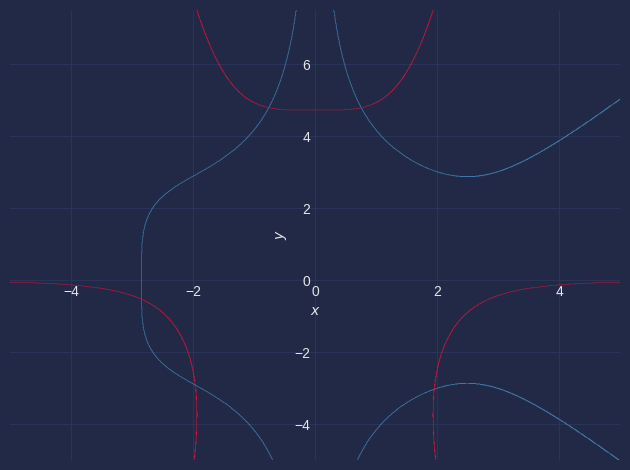

In [15]:
plot1 = plot_implicit(Eq(F[0], 0), (u, -5, 5), (v, -5, 7.5), line_color='steelblue', show=False)
plot2 = plot_implicit(Eq(F[1], 0), (u, -5, 5), (v, -5, 7.5), line_color='crimson', show=False)
plot1.append(plot2[0])
plot1.show()

## Почеум бы не вывести якобиан и обратный якобиан этой системы

In [16]:
printJacobian (F, syms)
printInvJacobian (F, syms)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Видно наличие 5 корней, получим все, из разных начальных условий:
## Области локализации:

In [17]:
areas = [[[0,2],[4,6]],
         [[-2,0],[4,6]],
         [[-4,-2],[-2,0]],
         [[-2,-1],[-4,-2]],
         [[1,2],[-4,-2]]]

list(map(lambda i, localArea: printAreaOfLocalization (list(symbols(f"x_{i},y_{i}")), localArea), range(1, 6), areas))

inceptionList = [[2., 4.],[-2., 4.],[-3., 0.],[-2., -3.],[2., -3.]]

print ('Будем начинать итерации с значений:')
list(map(lambda i, beginPoint: printBegin (list(symbols(f"x_{i},y_{i}")), beginPoint), range(1, 6), inceptionList));


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Будем начинать итерации с значений:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [19]:
inception = [Matrix(2,1, beg) for beg in inceptionList]

list(map(lambda begin: printAllResults (syms, F, *NewtonMethod (syms, F, begin, 10**(-5))), inception))
print('В целом все полученные корни получены буквально за несколько итерацией с искомой точностью и в целомм соотносятся с тем, что на графике')

<IPython.core.display.Latex object>

Достигнута искомая точность за 6 итераций
Невязка по первой норме = 2.2737367544323206e-13
Невязка по второй норме = 2.4158453015843406e-13
Невязка по третьей норме = 2.278173318171838e-13



<IPython.core.display.Latex object>

Достигнута искомая точность за 6 итераций
Невязка по первой норме = 4.547473508864641e-13
Невязка по второй норме = 4.689582056016661e-13
Невязка по третьей норме = 4.549693413077341e-13



<IPython.core.display.Latex object>

Достигнута искомая точность за 4 итераций
Невязка по первой норме = 3.2966909202514216e-09
Невязка по второй норме = 4.111484486202244e-09
Невязка по третьей норме = 3.39588862873667e-09



<IPython.core.display.Latex object>

Достигнута искомая точность за 3 итераций
Невязка по первой норме = 5.748249805037631e-07
Невязка по второй норме = 5.753509810801916e-07
Невязка по третьей норме = 5.748252211653191e-07



<IPython.core.display.Latex object>

Достигнута искомая точность за 3 итераций
Невязка по первой норме = 1.4551915228366852e-10
Невязка по второй норме = 1.5272405562427593e-10
Невязка по третьей норме = 1.456974066807814e-10

В целом все полученные корни получены буквально за несколько итерацией с искомой точностью и в целомм соотносятся с тем, что на графике
